# Text mining project

In [2]:
import nltk
import os
from gensim.models.doc2vec import Doc2Vec, TaggedDocument # doc2vec
import pandas as pd
import numpy as np

In [14]:
# models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [21]:
# results
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from utils import c_matrix

In [6]:
#setting working directory
os.chdir("C:/Users/fede9/Documents/GitHub/textmining/code")
from process_text import processing # preprocessing functions
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fede9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fede9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fede9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Preprocess text

In [8]:
if 'processed_data.csv' not in os.listdir('../data'):
    # load dataset
    df = pd.read_csv("../data/labeled_data.csv", sep = ",").drop("Unnamed: 0", axis=1)
    # apply process_text
    df["tweet_clean"] = df["tweet"].apply(lambda x : processing(x))
    df.to_csv('../data/processed_data.csv', index = False)
else:
    df = pd.read_csv("../data/processed_data.csv", sep = ",")
print("Load & preprocessing --- DONE")

Load & preprocessing --- DONE


In [9]:
# drop tweet list na !!!
df["tweet_list"] = df["tweet_clean"].str.split(" ").tolist()
df.dropna(inplace = True) # drop 2 NA

## Doc2vec

In [10]:
### doc2vec
# generate model of vectorization
if 'd2v.model' not in os.listdir('../models'):
    documents = [TaggedDocument (doc, [i]) for i, doc in enumerate(df["tweet_list"])]
    model = Doc2Vec (documents, vector_size=100, window=10, min_count=1)
    model.save("../models/d2v.model")
else:
    model = Doc2Vec.load("../models/d2v.model")
print("Doc2Vec model --- DONE")

Doc2Vec model --- DONE


## TF-IDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
vectorizer = TfidfVectorizer(
    use_idf=True,
    max_features=10000,
    min_df=5,
    max_df=0.501
    )

In [25]:
tfidf = vectorizer.fit_transform(df["tweet_clean"]).toarray()

In [31]:
tfidf.shape

(24781, 3598)

## Vader Sentiment

In [68]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\fede9\AppData\Roaming\nltk_data...


True

In [70]:
sentiments = []
sentiment_analyzer = VS()
for tweet in df['tweet_clean']:
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    sentiments.append(sentiment)

In [100]:
print(len(sentiments))
print(sentiments[:5])

24781
[{'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'compound': 0.2755}, {'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.5423}, {'neg': 0.841, 'neu': 0.159, 'pos': 0.0, 'compound': -0.9423}, {'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}, {'neg': 0.457, 'neu': 0.37, 'pos': 0.173, 'compound': -0.6808}]


In [76]:
df['tweet_clean'][0]

'woman shouldnt complain cleaning house man always take trash'

In [96]:
a = "life is now"

In [97]:
sentiment_analyzer.polarity_scores(a)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [103]:
neg = []
neu = []
pos = []
compound = []
for sentiment in sentiments:
    neg.append(sentiment['neg'])
    neu.append(sentiment['neu'])
    pos.append(sentiment['pos'])
    compound.append(sentiment['compound']) 

# save in dataframe  
df['neg'] = neg
df['neu'] = neu
df['pos'] = pos
df['compound'] = compound

In [105]:
df.neg 

0        0.000
1        0.259
2        0.841
3        0.000
4        0.457
         ...  
24778    0.000
24779    0.440
24780    0.000
24781    0.432
24782    0.000
Name: neg, Length: 24781, dtype: float64

SAREBBE BELLO PLOTTARE LE DISTRIBUZIONI x OGNI CLASSE PER MOSTRARE IL LORO LEGAME

## Vectorization (for doc2vec)

In [11]:
### vectorization
# vettori per tutti i documenti
df["vectors"] = df["tweet_list"].apply(lambda x: model.infer_vector(x))
print("Vectorization --- DONE")

Vectorization --- DONE


## Text classification

In [32]:
# prepare data
#X_data = np.stack(df["vectors"], axis = 0)
X_data = tfidf
Y_data = df["class"]

# verifica dimensioni vettori
assert X_data.shape[0] == Y_data.shape[0] 

In [33]:
# split train-test
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data,
                                                   test_size = 0.2,
                                                   random_state = 42,
                                                   shuffle = True,
                                                   stratify = Y_data)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

In [48]:
# class weights
# w_J = n_samples / (n_classes * n_samples_J)
weights = len(df['class']) / (3 * df['class'].value_counts())
# model
model = SVC(random_state = 42, 
            class_weight= {0 : weights[0], 1 : weights[1], 2 : weights[2]})

In [49]:
%%time
# fitting
model.fit(X_train, y_train)
print("Modelling --- DONE")

Modelling --- DONE
Wall time: 18min 52s


In [59]:
# save model
import pickle
filename = 'svm_tfidf.sav'
pickle.dump(model, open(f'../models/{filename}', 'wb'))

In [60]:
# load model
filename = 'svm_tfidf.sav'
model_2 = pickle.load(open(f'../models/{filename}', 'rb'))

## Performance

### Train

Classification report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.85      1144
           1       1.00      0.94      0.97     15351
           2       0.87      0.99      0.93      3329

    accuracy                           0.96     19824
   macro avg       0.87      0.98      0.92     19824
weighted avg       0.96      0.96      0.96     19824



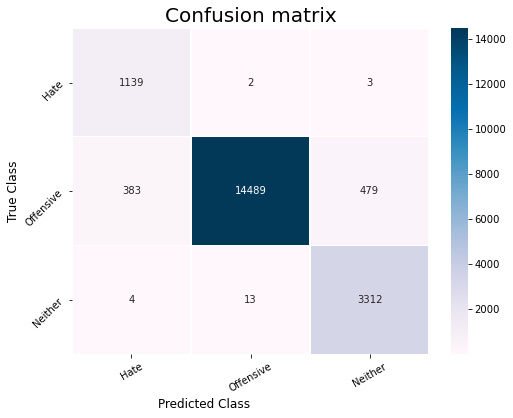

Wall time: 14min 15s


In [62]:
%%time
# performance on TRAIN
y_pred = model.predict(X_train)   
print('Classification report:')
print(classification_report(y_train, y_pred))
c_matrix(y_train, y_pred, ["Hate", "Offensive", "Neither"])

### Test

Classification report:
              precision    recall  f1-score   support

           0       0.44      0.43      0.44       286
           1       0.96      0.92      0.94      3838
           2       0.80      0.95      0.87       833

    accuracy                           0.90      4957
   macro avg       0.73      0.77      0.75      4957
weighted avg       0.90      0.90      0.90      4957



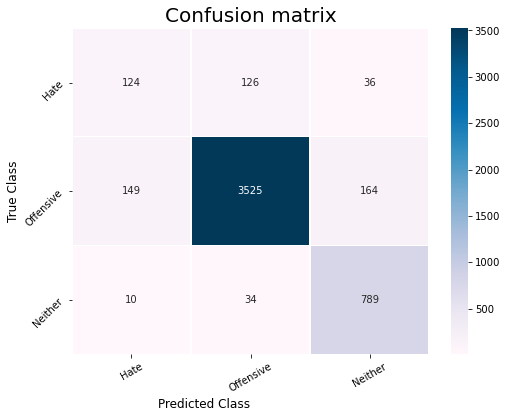

Wall time: 3min 31s


In [63]:
%%time
# performance on TEST
y_pred = model.predict(X_test)   
print('Classification report:')
print(classification_report(y_test, y_pred))
c_matrix(y_test, y_pred, ["Hate", "Offensive", "Neither"]) 